In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [13]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.unit_transformations import unit_direction_transformation
from project_ssms.feature_funcs import f_corner_vec_func, feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import downsample, k_step_prediction_for_artn_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces
from project_ssms.grid_utils import *

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time
import git
import joblib

# data

In [14]:
# read data and downsample by 2
repo = git.Repo('.', search_parent_directories=True)  # SocialBehaviorectories=True)
repo_dir = repo.working_tree_dir  # SocialBehavior

In [15]:
downsample_n = 2
video_clip_start = 0
video_clip_end = 5

data_dir = repo_dir + '/SocialBehaviorptc/data/trajs_all'
trajs = joblib.load(data_dir)

traj = trajs[36000*video_clip_start:36000*video_clip_end]
traj = downsample(traj, downsample_n)

data = torch.tensor(traj, dtype=torch.float64)

# model

In [24]:
# load model
checkpoint_dir = repo_dir + "/rslts/0827_v05/n2K6_4by4_D190827_004944/checkpoint_2/"
model_dir = checkpoint_dir + "model"

model = joblib.load(model_dir)

In [27]:
model.transition.stationary_transition_matrix

tensor([[7.6617e-01, 5.6873e-02, 9.6678e-02, 1.4530e-03, 7.8800e-02, 2.7836e-05],
        [1.8543e-02, 8.6006e-01, 2.8564e-02, 4.3193e-02, 3.0170e-02, 1.9472e-02],
        [3.3154e-02, 2.4270e-02, 8.1772e-01, 9.3818e-02, 1.8226e-02, 1.2811e-02],
        [2.2017e-04, 2.6895e-02, 6.5567e-02, 8.5556e-01, 8.9887e-03, 4.2766e-02],
        [3.3704e-02, 3.1150e-02, 1.8645e-02, 1.3018e-02, 8.0730e-01, 9.6182e-02],
        [1.9641e-04, 9.5958e-03, 9.4422e-03, 4.1520e-02, 4.7661e-02, 8.9158e-01]],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [120]:
numbers = joblib.load(checkpoint_dir+"numbers")

In [121]:
numbers.keys()

dict_keys(['z', 'x_predict', 'x_predict_5', 'sample_z', 'sample_x', 'sample_z_center', 'sample_x_center', 'losses'])

In [122]:
z = numbers['z']

In [125]:
z.shape

(90000,)

In [28]:
tran = model.observation.transformation

In [30]:
# find dominant transition

# get masks on all data
masks_a, masks_b = tran.get_masks(data)


In [33]:
out = np.diff(masks_a.numpy(), axis=-1)

In [34]:
out.shape

(16, 89999)

In [132]:
def get_tijs(masks):
    G, T = masks.shape
    out = np.diff(masks, axis=-1) # (G, T-1)
    
    t_ijs = [[[] for _ in range(G)] for _ in range(G)]
    
    for i in range(G):
        for j in range(G):
            if j == i:
                continue
            # grid i -> j from t -> t+1
            t_ijs[i][j] = np.where(out[j] - out[i] == 2)[0]
    return t_ijs

In [152]:
tijs_a = get_tijs(masks_a.numpy())  # (16 by 16)

In [178]:
G = 16

In [179]:
K = model.K
possible_transitions = [(i,j) for i in range(K) for j in range(K)]

In [331]:
def print_summary(tijs, z):
    T = len(z)
    grid_transition_counts = {}
    for i in range(G):
        for j in range(G):
            # do not care about staying in the same grid
            if i == j:
                continue
            # do not care about no transitioning from grid i to j
            if len(tijs[i][j]) == 0:
                continue

            transition_counts = dict.fromkeys(possible_transitions, 0)
            for t in tijs[i][j]:
                if t + 2 > T - 1:
                    continue
                transition = (z[t+1], z[t+2])
                transition_counts[transition] += 1

            grid_transition_counts[(i,j)] = transition_counts

            print("From grid {} to grid {}".format(i, j))

            print("  Not switching states...")
            count = 0
            for key, val in transition_counts.items():
                if key[0] == key[1]:
                    if val != 0:
                        print("    Count of transitions k={} -> k={}: {}".format(key[0], key[1], val))
                        count += val
            #print("  total_count = {}".format(count))

            print("  Switching states...")
            count = 0
            for key, val in transition_counts.items():
                if key[0] != key[1]:
                    if val != 0:
                        print("    Count of transitions k={} -> k={}: {}".format(key[0], key[1], val))
                        count += val
            #print("  total_count = {}".format(count))

def print_summary_2(tijs, z):
    T = len(z)
    grid_transition_counts = {}
    for i in range(G):
        for j in range(G):
            # do not care about staying in the same grid
            if i == j:
                continue
            # do not care about no transitioning from grid i to j
            if len(tijs[i][j]) == 0:
                continue

            transition_counts = dict.fromkeys(possible_transitions, 0)
            for t in tijs[i][j]:
                if t + 2 > T-1:
                    continue
                transition = (z[t+1], z[t+2])
                transition_counts[transition] += 1

            grid_transition_counts[(i,j)] = transition_counts

            count_1 = 0
            for key, val in transition_counts.items():
                if key[0] == key[1]:
                    if val != 0:
                        #print("    Count of transitions k={} -> k={}: {}".format(key[0], key[1], val))
                        count_1 += val

            count_2 = 0
            for key, val in transition_counts.items():
                if key[0] != key[1]:
                    if val != 0:
                        #print("    Count of transitions k={} -> k={}: {}".format(key[0], key[1], val))
                        count_2 += val
            print("From grid {} to grid {}, ({}, {})".format(i, j, count_1, count_2))
        
                    
        

In [337]:
print_summary(tijs_a, z)

From grid 0 to grid 1
  Not switching states...
    Count of transitions k=0 -> k=0: 1
    Count of transitions k=5 -> k=5: 1
  Switching states...
    Count of transitions k=5 -> k=3: 1
From grid 0 to grid 4
  Not switching states...
    Count of transitions k=0 -> k=0: 1
    Count of transitions k=1 -> k=1: 2
    Count of transitions k=2 -> k=2: 1
  Switching states...
From grid 1 to grid 0
  Not switching states...
    Count of transitions k=0 -> k=0: 1
    Count of transitions k=1 -> k=1: 1
    Count of transitions k=2 -> k=2: 1
  Switching states...
    Count of transitions k=1 -> k=2: 1
    Count of transitions k=3 -> k=5: 1
From grid 1 to grid 2
  Not switching states...
    Count of transitions k=0 -> k=0: 15
    Count of transitions k=2 -> k=2: 2
  Switching states...
From grid 1 to grid 5
  Not switching states...
    Count of transitions k=2 -> k=2: 7
  Switching states...
From grid 2 to grid 1
  Not switching states...
    Count of transitions k=0 -> k=0: 3
    Count of tra

In [333]:
print_summary_2(tijs_a, z)

From grid 0 to grid 1, (2, 1)
From grid 0 to grid 4, (4, 0)
From grid 1 to grid 0, (3, 2)
From grid 1 to grid 2, (17, 0)
From grid 1 to grid 5, (7, 0)
From grid 2 to grid 1, (16, 3)
From grid 2 to grid 3, (25, 5)
From grid 2 to grid 5, (1, 0)
From grid 2 to grid 6, (4, 0)
From grid 3 to grid 2, (17, 7)
From grid 3 to grid 7, (33, 4)
From grid 4 to grid 0, (1, 1)
From grid 4 to grid 1, (1, 0)
From grid 4 to grid 5, (6, 0)
From grid 4 to grid 8, (13, 4)
From grid 4 to grid 9, (1, 0)
From grid 5 to grid 1, (6, 0)
From grid 5 to grid 4, (5, 3)
From grid 5 to grid 6, (6, 0)
From grid 5 to grid 9, (4, 0)
From grid 6 to grid 2, (12, 1)
From grid 6 to grid 5, (3, 1)
From grid 6 to grid 7, (8, 0)
From grid 6 to grid 10, (2, 1)
From grid 7 to grid 3, (27, 4)
From grid 7 to grid 6, (10, 0)
From grid 7 to grid 11, (16, 7)
From grid 8 to grid 4, (12, 3)
From grid 8 to grid 5, (1, 0)
From grid 8 to grid 9, (8, 2)
From grid 8 to grid 12, (17, 2)
From grid 9 to grid 5, (5, 1)
From grid 9 to grid 6, (1

In [334]:
tijs_b = get_tijs(masks_b.numpy())  # (16 by 16)

In [338]:
print_summary(tijs_b, z)

From grid 0 to grid 1
  Not switching states...
    Count of transitions k=0 -> k=0: 6
    Count of transitions k=1 -> k=1: 29
    Count of transitions k=2 -> k=2: 22
    Count of transitions k=3 -> k=3: 16
    Count of transitions k=4 -> k=4: 15
    Count of transitions k=5 -> k=5: 5
  Switching states...
    Count of transitions k=0 -> k=1: 1
    Count of transitions k=0 -> k=2: 3
    Count of transitions k=1 -> k=2: 3
    Count of transitions k=1 -> k=3: 1
    Count of transitions k=2 -> k=1: 2
    Count of transitions k=2 -> k=3: 2
    Count of transitions k=3 -> k=2: 1
    Count of transitions k=4 -> k=5: 1
    Count of transitions k=5 -> k=1: 1
From grid 0 to grid 4
  Not switching states...
    Count of transitions k=0 -> k=0: 7
    Count of transitions k=1 -> k=1: 4
    Count of transitions k=2 -> k=2: 2
    Count of transitions k=3 -> k=3: 2
    Count of transitions k=4 -> k=4: 23
    Count of transitions k=5 -> k=5: 10
  Switching states...
    Count of transitions k=0 -> k=2

In [336]:
print_summary_2(tijs_b, z)

From grid 0 to grid 1, (93, 15)
From grid 0 to grid 4, (48, 2)
From grid 0 to grid 5, (0, 1)
From grid 1 to grid 0, (105, 11)
From grid 1 to grid 2, (32, 13)
From grid 1 to grid 5, (11, 4)
From grid 2 to grid 1, (33, 8)
From grid 2 to grid 3, (26, 13)
From grid 2 to grid 6, (5, 1)
From grid 3 to grid 2, (23, 1)
From grid 3 to grid 7, (47, 16)
From grid 4 to grid 0, (37, 4)
From grid 4 to grid 5, (43, 7)
From grid 4 to grid 8, (60, 16)
From grid 5 to grid 0, (2, 0)
From grid 5 to grid 1, (23, 5)
From grid 5 to grid 2, (2, 0)
From grid 5 to grid 4, (44, 9)
From grid 5 to grid 6, (6, 2)
From grid 5 to grid 8, (1, 0)
From grid 5 to grid 9, (6, 4)
From grid 6 to grid 2, (10, 4)
From grid 6 to grid 5, (13, 5)
From grid 6 to grid 7, (10, 7)
From grid 6 to grid 10, (5, 1)
From grid 7 to grid 2, (0, 1)
From grid 7 to grid 3, (43, 5)
From grid 7 to grid 6, (13, 5)
From grid 7 to grid 11, (24, 17)
From grid 8 to grid 4, (56, 8)
From grid 8 to grid 9, (20, 0)
From grid 8 to grid 12, (85, 14)
From 

Now, try to understand why the quiver is not continuous for fixed K.

In [339]:
tijs_b[4][5]

array([ 2663,  7109,  7407,  9679, 10412, 13110, 16518, 30720, 34192,
       40282, 41133, 41160, 44285, 44748, 45200, 45838, 49118, 49123,
       50128, 51417, 51457, 51468, 51470, 51477, 51509, 51513, 51517,
       51526, 51546, 58030, 71266, 71272, 74500, 79017, 79421, 79426,
       79431, 79438, 79440, 79454, 79462, 79467, 79525, 79527, 79529,
       79531, 79536, 79540, 79713, 88985])

In [342]:
for t in tijs_b[4][5]:
    if z[t+1] == 1 and z[t+2] == 1:
        print("yes", t)

yes 79421


In [345]:
for t in tijs_b[5][4]:
    if z[t+1] == 1 and z[t+2] == 1:
        print("yes", t)

yes 5663
yes 14597
yes 35433
yes 49137


In [343]:
data[79421]

tensor([291.7145, 313.2207, 101.3721,  89.1800], dtype=torch.float64)

In [252]:
from project_ssms.grid_utils import plot_realdata_quiver

In [253]:
x_grids = tran.x_grids
y_grids = tran.y_grids

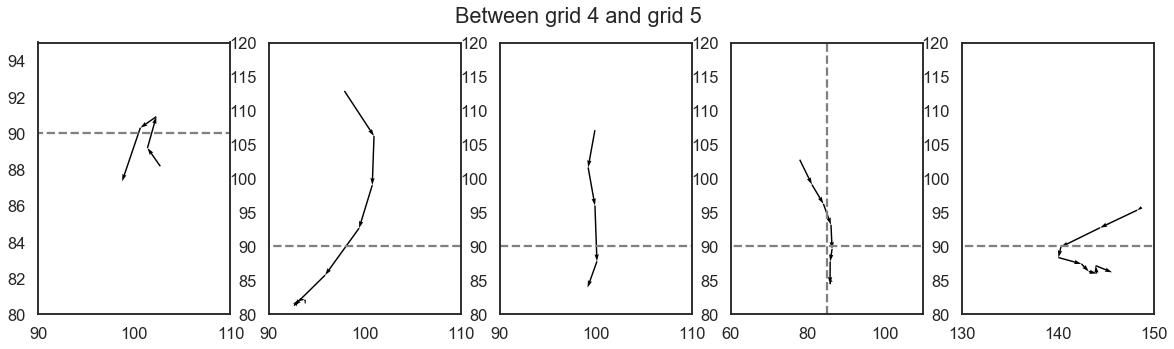

In [378]:
plt.figure(figsize=(20,5))

plt.suptitle("Between grid 4 and grid 5")
plt.subplot(1,5,1)
plot_realdata_quiver(data[79420:79425, 2:4], x_grids, y_grids, scale=1, xlim=(90,110), ylim=(80,95))

plt.subplot(1,5,2)
plot_realdata_quiver(data[5660:5670, 2:4], x_grids, y_grids, scale=1, xlim=(90,110), ylim=(80,120))

plt.subplot(1,5,3)
plot_realdata_quiver(data[14595:14600, 2:4], x_grids, y_grids, scale=1, xlim=(90,110), ylim=(80,120))

plt.subplot(1,5,4)
plot_realdata_quiver(data[35430:35440, 2:4], x_grids, y_grids, scale=1, xlim=(60,110), ylim=(80,120))

plt.subplot(1,5,5)
plot_realdata_quiver(data[49135:49145, 2:4], x_grids, y_grids, scale=1, xlim=(130,150), ylim=(80,120))

# sample condition on fixed z

In [429]:
torch.manual_seed(10)
np.random.seed(10)

In [430]:
x0 = np.array([100,250,100,250])

In [431]:
fixed_z_0 = np.array([0 for _ in range(5000)])
sample_on_z0 = model.sample_condition_on_zs(fixed_z_0, x0)

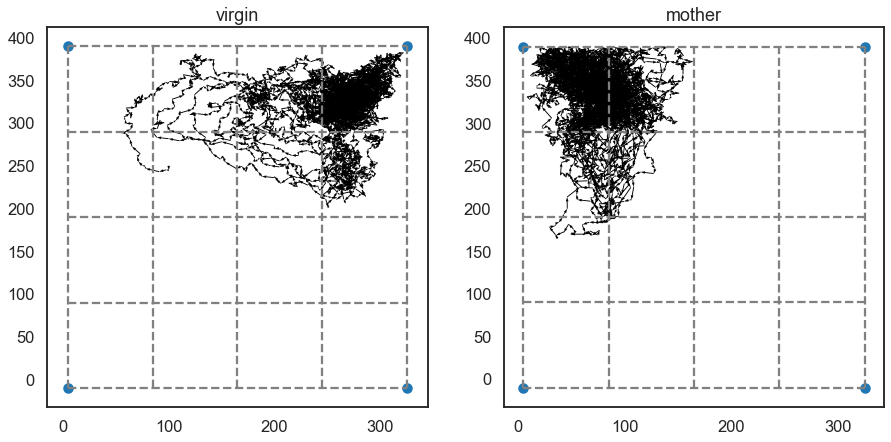

In [432]:
plot_realdata_quiver(sample_on_z0, x_grids, y_grids, scale=1)

In [433]:
fixed_z_1 = np.array([1 for _ in range(5000)])
sample_on_z1 = model.sample_condition_on_zs(fixed_z_1, x0)

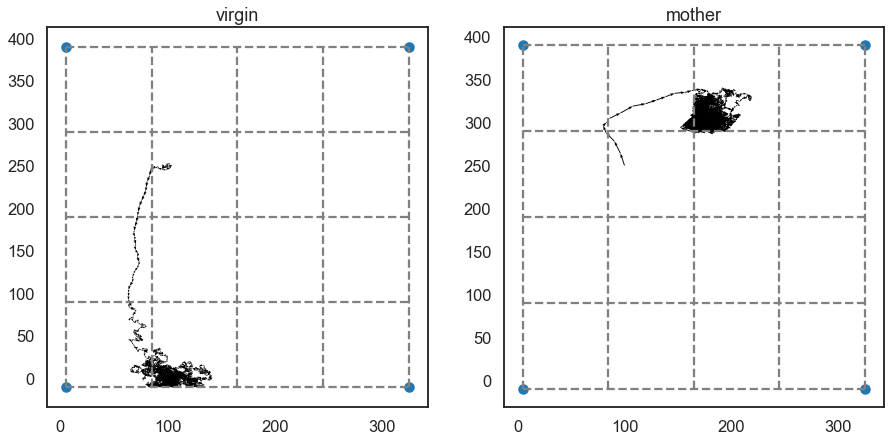

In [434]:
plot_realdata_quiver(sample_on_z1, x_grids, y_grids, scale=1)

In [435]:
fixed_z_2 = np.array([2 for _ in range(5000)])
sample_on_z2 = model.sample_condition_on_zs(fixed_z_2, x0)

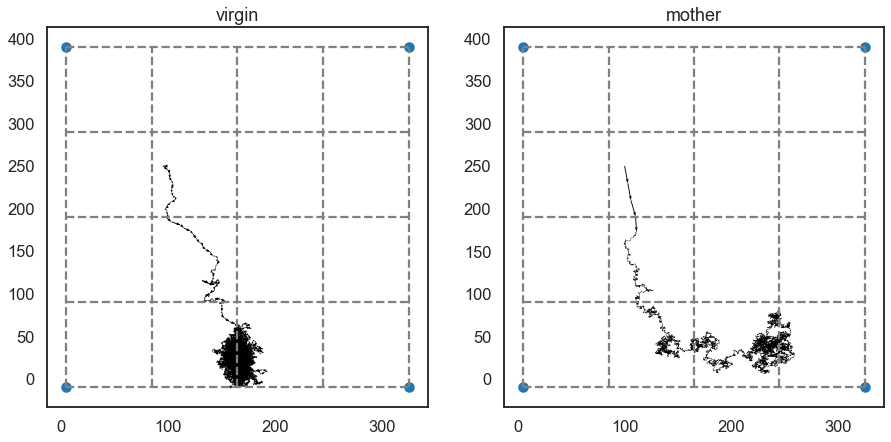

In [436]:
plot_realdata_quiver(sample_on_z2, x_grids, y_grids, scale=1)

In [437]:
fixed_z_3 = np.array([3 for _ in range(5000)])
sample_on_z3 = model.sample_condition_on_zs(fixed_z_3, x0)

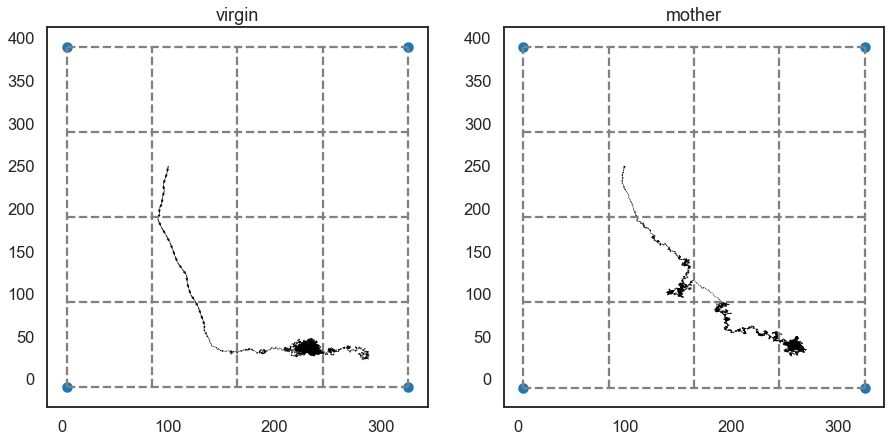

In [438]:
plot_realdata_quiver(sample_on_z3, x_grids, y_grids, scale=1)

In [439]:
fixed_z_4 = np.array([4 for _ in range(5000)])
sample_on_z4 = model.sample_condition_on_zs(fixed_z_4, x0)

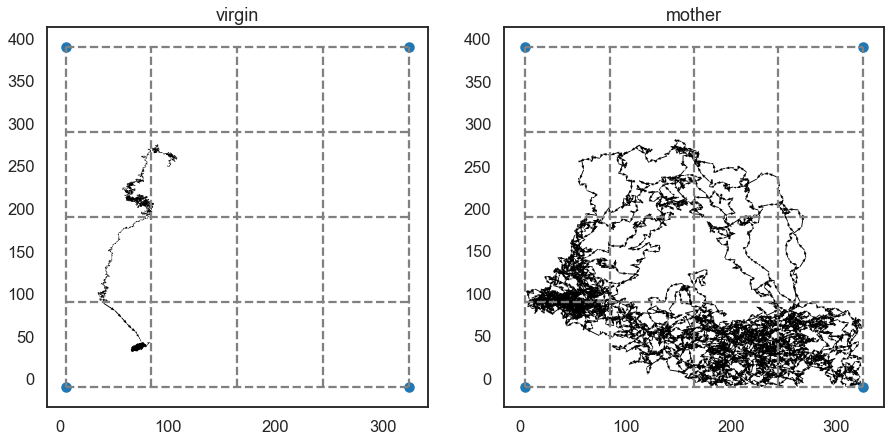

In [440]:
plot_realdata_quiver(sample_on_z4, x_grids, y_grids, scale=1)

In [441]:
fixed_z_5 = np.array([5 for _ in range(5000)])
sample_on_z5 = model.sample_condition_on_zs(fixed_z_5, x0)

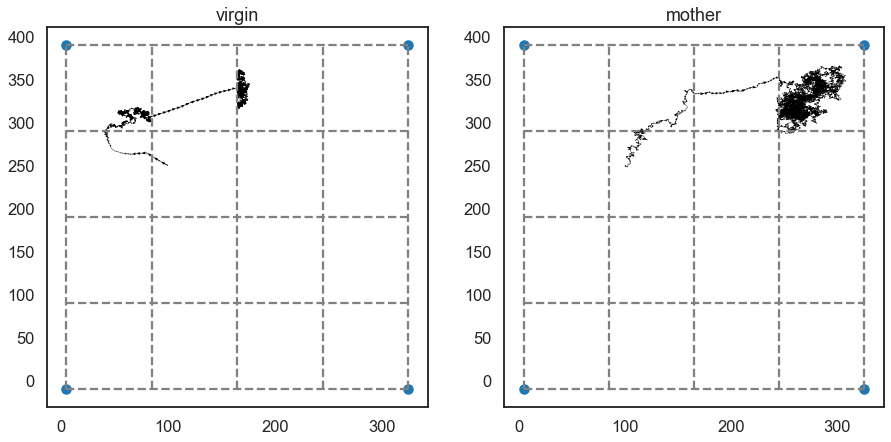

In [442]:
plot_realdata_quiver(sample_on_z5, x_grids, y_grids, scale=1)

In [452]:
model.transition.params[0].requires_grad=True

In [453]:
len(model.trainable_params)

35

In [455]:
len(model.trainable_params)

34

In [454]:
model.transition.params[0].requires_grad=False

In [457]:
model.observation.bounds

tensor([[  5., 325.],
        [-10., 390.],
        [  5., 325.],
        [-10., 390.]], dtype=torch.float64)

In [458]:
data.shape

torch.Size([90000, 4])

In [483]:
fixed_Pi = torch.tensor([[7, 1, 1, 1, 1, 1],
                         [1, 7, 1, 1, 1, 1],
                         [1, 1, 7, 1, 1, 1],
                         [1, 1, 1, 7, 1, 1],
                         [1, 1, 1, 1, 7, 1],
                         [1, 1, 1, 1, 1, 7]], dtype=torch.float64)

In [493]:
def get_model_restart(model):
    bounds = model.observation.bounds
    x_grids = model.observation.transformation.x_grids
    y_grids = model.observation.transformation.y_grids
    Df = model.observation.transformation.transformations_a[0].Df
    
    K = model.K
    D = model.D
    M = model.M
    
    feature_vec = model.observation.transformation.transformations_a[0].feature_vec_func
    acc_factor = model.observation.transformation.transformations_a[0].acc_factor
        
    tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, unit_transformation="direction",
                                  Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=acc_factor)
    
    obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

    transition_kwargs = None
    
    model_restart = HMM(K=K, D=D, M=M, transition="stationary", observation=obs, transition_kwargs=transition_kwargs)
    model_restart.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)
    
    model_restart.transition.params[0].requires_grad= False
    model_restart.transition.params = (fixed_Pi, )
    
    return model_restart


In [494]:
model4by4_restart = get_model_restart(model)

In [495]:
len(model4by4_restart.trainable_params)

34

In [484]:
model.transition.params

(tensor([[ 3.4817,  0.8811,  1.4117, -2.7861,  1.2072, -6.7412],
         [-0.8151,  3.0218, -0.3830,  0.0305, -0.3283, -0.7662],
         [-0.5275, -0.8394,  2.6779,  0.5127, -1.1258, -1.4783],
         [-5.1384, -0.3331,  0.5581,  3.1268, -1.4290,  0.1307],
         [-0.5011, -0.5799, -1.0932, -1.4524,  2.6749,  0.5475],
         [-4.8469, -0.9580, -0.9742,  0.5068,  0.6447,  3.5736]],
        dtype=torch.float64),)

In [485]:
torch.nn.Softmax(dim=1)(fixed_Pi)

tensor([[0.9878, 0.0024, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.9878, 0.0024, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.9878, 0.0024, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.9878, 0.0024, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.9878, 0.0024],
        [0.0024, 0.0024, 0.0024, 0.0024, 0.0024, 0.9878]], dtype=torch.float64)

In [488]:
model.transition.params = (fixed_Pi, )

In [496]:
len(model.trainable_params)

34

In [497]:
joblib.dump(model, "modeln2K6_4by4")

['modeln2K6_4by4']

In [498]:
joblib.dump(model4by4_restart, "modeln2K6_4by4_restart")

['modeln2K6_4by4_restart']

In [503]:
model6by6_dir = repo_dir + "/rslts/0827_v05/n2K6_6by6_D190827_004903/checkpoint_2/model"

In [504]:
model6by6 = joblib.load(model6by6_dir)

In [505]:
len(model6by6.trainable_params)

75

In [523]:
model6by6.transition.params = (fixed_Pi, )

In [524]:
model6by6.transition.params[0].requires_grad = False

In [525]:
len(model6by6.trainable_params)

74

In [526]:
model6by6_restart = get_model_restart(model6by6)

In [529]:
len(model6by6_restart.trainable_params)

74

In [530]:
joblib.dump(model6by6, "modeln2K6_6by6")

['modeln2K6_6by6']

In [531]:
joblib.dump(model6by6_restart, "modeln2K6_6by6_restart")

['modeln2K6_6by6_restart']

In [532]:
model8by8_dir = repo_dir + "/rslts/0827_v05/n2K6_8by8_D190827_004858/checkpoint_2/model"

In [533]:
model8by8 = joblib.load(model8by8_dir)

In [534]:
len(model8by8.trainable_params)

131

In [536]:
model8by8.transition.params = (fixed_Pi, )

In [537]:
model8by8.transition.params[0].requires_grad = False

In [538]:
len(model8by8.trainable_params)

130

In [539]:
model8by8_restart = get_model_restart(model8by8)

In [540]:
len(model8by8_restart.trainable_params)

130

In [541]:
joblib.dump(model8by8, "modeln2K6_8by8")

['modeln2K6_8by8']

In [542]:
joblib.dump(model8by8_restart, "modeln2K6_8by8_restart")

['modeln2K6_8by8_restart']

In [556]:
# try a transition matrix that is closer to identity
fixed_P_stricter = torch.tensor([[10, 1, 1, 1, 1, 1], [1, 10, 1, 1, 1, 1], [1, 1, 10, 1, 1, 1], 
                                [1, 1, 1, 10, 1, 1], [1, 1, 1, 1, 10, 1], [1, 1, 1, 1, 1, 10]], dtype=torch.float64)

In [557]:
fixed_P_stricter.shape

torch.Size([6, 6])

In [560]:
model.transition.params = (fixed_P_stricter, )
model4by4_restart.transition.params = (fixed_P_stricter, )
model6by6.transition.params = (fixed_P_stricter, )
model6by6_restart.transition.params = (fixed_P_stricter, )
model8by8.transition.params = (fixed_P_stricter, )
model8by8_restart.transition.params = (fixed_P_stricter, )

In [561]:
joblib.dump(model, "saved_models_strict/modeln2K6_4by4")
joblib.dump(model4by4_restart, "saved_models_strict/modeln2K6_4by4_restart")
joblib.dump(model6by6, "saved_models_strict/modeln2K6_6by6")
joblib.dump(model6by6_restart, "saved_models_strict/modeln2K6_6by6_restart")
joblib.dump(model8by8, "saved_models_strict/modeln2K6_8by8")
joblib.dump(model8by8_restart, "fixed_Pi_stricter/modeln2K6_8by8_restart")

FileNotFoundError: [Errno 2] No such file or directory: 'fixed_Pi_stricter/modeln2K6_4by4'